In [1]:
import VariationalBayes as vb
import LogisticGLMM_lib as logit_glmm
from VariationalBayes.SparseObjectives import Objective

import matplotlib.pyplot as plt
%matplotlib inline

#import numpy as np

import autograd
import autograd.numpy as np

import copy
from scipy import optimize

import os
import json

import time

import pickle


In [2]:
# Load data saved by stan_results_to_json.R and run_stan.R in LRVBLogitGLMM.

analysis_name = 'simulated_data_small'
#analysis_name = 'criteo_subsampled'

data_dir = os.path.join(os.environ['GIT_REPO_LOC'],
                        'LinearResponseVariationalBayes.py/Models/LogisticGLMM/data')
json_filename = os.path.join(data_dir, '%s_stan_dat.json' % analysis_name)

json_file = open(json_filename, 'r')
json_dat = json.load(json_file)
json_file.close()

stan_dat = json_dat['stan_dat']
#vp_base = json_dat['vp_base']

print(stan_dat.keys())
K = stan_dat['K'][0]
NObs = stan_dat['N'][0]
NG = stan_dat['NG'][0]
#N = NObs / NG
y_g_vec = np.array(stan_dat['y_group'])
y_vec = np.array(stan_dat['y'])
x_mat = np.array(stan_dat['x'])

glmm_par = logit_glmm.get_glmm_parameters(K=K, NG=NG)

# Define a class to contain prior parameters.
prior_par = logit_glmm.get_default_prior_params(K)
prior_par['beta_prior_mean'].set(np.array(stan_dat['beta_prior_mean']))

prior_par['beta_prior_info'].set(np.array(stan_dat['beta_prior_info']))

prior_par['mu_prior_mean'].set(stan_dat['mu_prior_mean'][0])
prior_par['mu_prior_info'].set(stan_dat['mu_prior_info'][0])

prior_par['tau_prior_alpha'].set(stan_dat['tau_prior_alpha'][0])
prior_par['tau_prior_beta'].set(stan_dat['tau_prior_beta'][0])

# An index set to make sure jacobians match the order expected by R.
prior_par_indices = copy.deepcopy(prior_par)
prior_par_indices.set_name('Prior Indices')
prior_par_indices.set_vector(np.array(range(prior_par_indices.vector_size())))

free_par_vec = glmm_par.get_free()
init_par_vec = copy.deepcopy(free_par_vec)

print(np.mean(y_vec))

dict_keys(['x', 'K', 'NG', 'beta_prior_info', 'tau_prior_alpha', 'y', 'tau_prior_beta', 'mu_prior_info', 'N', 'y_group', 'beta_prior_mean', 'mu_prior_mean'])
0.324


In [3]:
# Define moment parameters
moment_wrapper = logit_glmm.MomentWrapper(glmm_par)
get_moment_jacobian = autograd.jacobian(moment_wrapper.get_moment_vector)
moment_jac = get_moment_jacobian(init_par_vec)

model = logit_glmm.LogisticGLMM(glmm_par, prior_par, x_mat, y_vec, y_g_vec, num_gh_points=10)
model.get_e_log_prior()
model.get_log_lik()
model.get_entropy()

objective = Objective(model.glmm_par, model.get_kl)
objective.fun_free(free_par_vec)

# # PriorHess evaluates the second order derivative d2 EPrior / dpar dprior_par
def get_e_log_prior(prior_vec, free_par):
    model.glmm_par.set_free(free_par)
    model.prior_par.set_vector(prior_vec)
    return model.get_e_log_prior()

get_prior_model_grad = autograd.grad(get_e_log_prior, argnum=0)
get_prior_hess = autograd.jacobian(get_prior_model_grad, argnum=1)

import timeit

time_num = 10

num_draws = 3
model.set_gh_points(num_draws)
print('num_draws = ', num_draws)
print('\tFunction time:',
      timeit.timeit(lambda: objective.fun_free(free_par_vec), number=time_num) / time_num)

print('\tGrad time:', 
      timeit.timeit(lambda: objective.fun_free_grad(free_par_vec), number=time_num) / time_num)

print('\tHessian vector product time:',
      timeit.timeit(lambda: objective.fun_free_hvp(free_par_vec, free_par_vec + 1), number=time_num) / time_num)

prior_vec = model.prior_par.get_vector()
prior_hess_time = time.time()
get_prior_hess(prior_vec, init_par_vec)
prior_hess_time = time.time() - prior_hess_time
print('\tPrior hess time: ', prior_hess_time)


num_draws =  3
	Function time: 0.0005480531021021306
	Grad time: 0.005122432898497209
	Hessian vector product time: 0.010981464700307697
	Prior hess time:  0.06104087829589844


In [4]:

glmm_par.set_free(np.random.random(glmm_par.free_size()))

sparse_model = logit_glmm.SparseModelObjective(glmm_par, prior_par, x_mat, y_vec, y_g_vec, 4)

sparse_model.set_group_parameters(1)
sparse_model.get_group_elbo(1)

sparse_model.set_global_parameters()
sparse_model.get_global_elbo()



array([ 3.15645733])

In [5]:


print('Gettin\' that ol\' Hessian:')

full_hess_time = time.time()
full_hess = sparse_model.get_vector_hessian(sparse_model.glmm_par.get_vector())
full_hess_time = time.time() - full_hess_time

print('Full Hessian time: ', full_hess_time)



Gettin' that ol' Hessian:
Full Hessian time:  1.843390703201294


In [6]:
sparse_hess_time = time.time()
sparse_hess = sparse_model.get_sparse_vector_hessian(print_every=10)
sparse_hess_time = time.time() - sparse_hess_time

Calculating global hessian:
Group 0 of 0
Done.
Calculating local hessian:
Group 0 of 99
Group 10 of 99
Group 20 of 99
Group 30 of 99
Group 40 of 99
Group 50 of 99
Group 60 of 99
Group 70 of 99
Group 80 of 99
Group 90 of 99
Done.


In [7]:
print('Max difference (should be zero):', np.max(np.abs(full_hess - sparse_hess.todense())))
print('Stdev (so you know it\'s not all zeros):', np.std(full_hess[:]))
print('\n')

print('Sparse Hessian time: ', sparse_hess_time)
print('Sparse Hessian time per group: ', sparse_hess_time  / float(NG))

print('Full Hessian time: ', full_hess_time)
print('Sparse Hessian time: ', sparse_hess_time)



Max difference (should be zero): 5.68434188608e-14
Stdev (so you know it's not all zeros): 1.59696268349


Sparse Hessian time:  8.0006103515625
Sparse Hessian time per group:  0.080006103515625
Full Hessian time:  1.843390703201294
Sparse Hessian time:  8.0006103515625


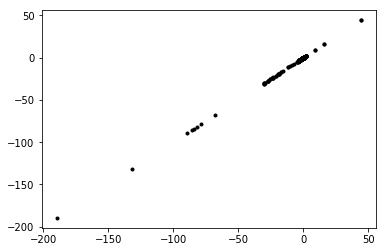

In [8]:
plt.plot(full_hess.flatten(), np.asarray(sparse_hess.todense()).flatten(), 'k.')

In [16]:
objective = Objective(sparse_model.glmm_par, sparse_model.get_elbo)
print('Calculating the dense free Hessian')
dense_free_hess = objective.fun_free_hessian(sparse_model.glmm_par.get_free())
print('done')

In [17]:

print('Transforming to the sparse free Hessian')
sparse_free_hess = sparse_model.get_free_hessian(sparse_hess)
print('Done')

Transforming to the sparse free Hessian


AttributeError: 'SparseModelObjective' object has no attribute 'get_free_hessian'

5.68434188608e-14


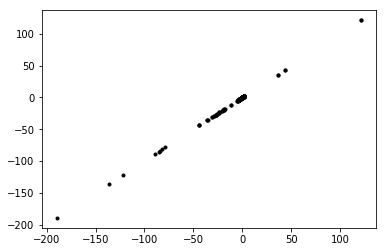

In [14]:
print(np.max(np.abs(dense_free_hess.flatten() - np.asarray(sparse_free_hess.todense()).flatten())))
plt.plot(dense_free_hess.flatten(), np.asarray(sparse_free_hess.todense()).flatten(), 'k.')